In [6]:
import os
import ipynb
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import statistics
from scipy.stats import loguniform

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

from sklearn.svm import SVC

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.metrics import classification_report

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb
from ipynb.fs.full.accuracy_plots import cumulative_accuracy_plot #import fx from accuracy_plots.ipynb
from ipynb.fs.full.accuracy_plots import accuracy_by_nfeatures #import fx from accuracy_plots.ipynb

In [7]:
#Restore saved dataframes from 00_EDA.ipynb
%store -r prep_dwt_8 prep_wang_8 prep_jones_8

%store -r dwt_8 wang_8 jones_8
dwt_8 = dwt_8
wang_8 = wang_8
jones_8 = jones_8

%store -r dwt_topten_8 wang_topten_8 jones_topten_8
dwt_topten_8 = dwt_topten_8
wang_topten_8 = wang_topten_8
jones_topten_8 = jones_topten_8

%store -r dwt_4 wang_4 jones_4
dwt_4 = dwt_4
wang_4 = wang_4
jones_4 = jones_4

%store -r dwt_topten_4 wang_topten_4 jones_topten_4
dwt_topten_4 = dwt_topten_4
wang_topten_4 = wang_topten_4
jones_topten_4 = jones_topten_4


## SVM (balanced sampling, default parameters)

In [5]:
def svm(df, n_iter=1000, balanced=False):

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        if(balanced == False):

            subset_0 = df[df['state'] == 0]
            subset_1 = df[df['state'] == 1]

            subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
            df = pd.concat([subset_0, subset_1])
                     
        x = df.loc[:, df.columns != 'state'] #features
        y = df.loc[:, df.columns == 'state'] #supervisor

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        svm_model = SVC()
        svm_model.fit(x_train, y_train.values.ravel())
        
        y_pred = svm_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = svm_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [6]:
acc_dwt_8 = svm(dwt_8, n_iter=10000)
acc_wang_8 = svm(wang_8, n_iter=10000)
acc_jones_8 = svm(jones_8, n_iter=10000)

print('DWT Method Accuracy ', round(acc_dwt_8['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_wang_8['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_jones_8['accuracy'].mean(), 4))

DWT Method Accuracy  0.9431
Wang Method Accuracy  0.9448
Jones Method Accuracy  0.8767


## Accuracy by n Fisher's features

In [7]:
svm_feat_accuracy_dwt = accuracy_by_nfeatures(class_instance=prep_dwt_8, file_name='DWT', classifier=svm, n_features=29, n_iter=1000)
svm_feat_accuracy_wang = accuracy_by_nfeatures(class_instance=prep_wang_8, file_name='Wang', classifier=svm, n_features=29, n_iter=1000)
svm_feat_accuracy_jones = accuracy_by_nfeatures(class_instance=prep_jones_8, file_name='Jones', classifier=svm, n_features=29, n_iter=1000)

In [8]:
svm_feat_accuracy_dwt = svm_feat_accuracy_dwt.rename(
                                columns = lambda col: f"{col}_dwt" 
                                if col not in ('n_features', 'file_name') else col)

svm_feat_accuracy_wang = svm_feat_accuracy_wang.rename(
                                columns = lambda col: f"{col}_wang" 
                                if col not in ('n_features', 'file_name') else col)

svm_feat_accuracy_jones = svm_feat_accuracy_jones.rename(
                                columns = lambda col: f"{col}_jones" 
                                if col not in ('n_features', 'file_name') else col)     

In [9]:
#merge three dataframes on n_features
merged_feat_accuracy_svm = svm_feat_accuracy_dwt.merge(svm_feat_accuracy_wang, how='right', on='n_features').merge(svm_feat_accuracy_jones, how='right', on='n_features')

merged_feat_accuracy_svm.head()

,n_features,file_name_x,mean_dwt,stdev_dwt,mean_train_dwt,stdev_train_dwt,file_name_y,mean_wang,stdev_wang,mean_train_wang,stdev_train_wang,file_name,mean_jones,stdev_jones,mean_train_jones,stdev_train_jones
0,1,DWT,0.785,0.044429,0.797884,0.021945,Wang,0.768885,0.043723,0.784669,0.023349,Jones,0.709246,0.049955,0.732041,0.029225
1,2,DWT,0.877197,0.034731,0.890331,0.018219,Wang,0.856459,0.03885,0.883769,0.018183,Jones,0.784426,0.046221,0.820512,0.022981
2,3,DWT,0.908623,0.02987,0.936752,0.014484,Wang,0.895689,0.030417,0.923727,0.016039,Jones,0.786557,0.04461,0.831347,0.024477
3,4,DWT,0.926852,0.026733,0.950149,0.012439,Wang,0.933279,0.027578,0.97638,0.011006,Jones,0.819197,0.039826,0.869149,0.019604
4,5,DWT,0.937951,0.025382,0.955471,0.012407,Wang,0.927393,0.02878,0.96338,0.012887,Jones,0.783705,0.041882,0.844033,0.022605


In [11]:
%store merged_feat_accuracy_svm

Stored 'merged_feat_accuracy_svm' (DataFrame)


In [8]:
%store -r merged_feat_accuracy_svm #restore

no stored variable or alias #restore


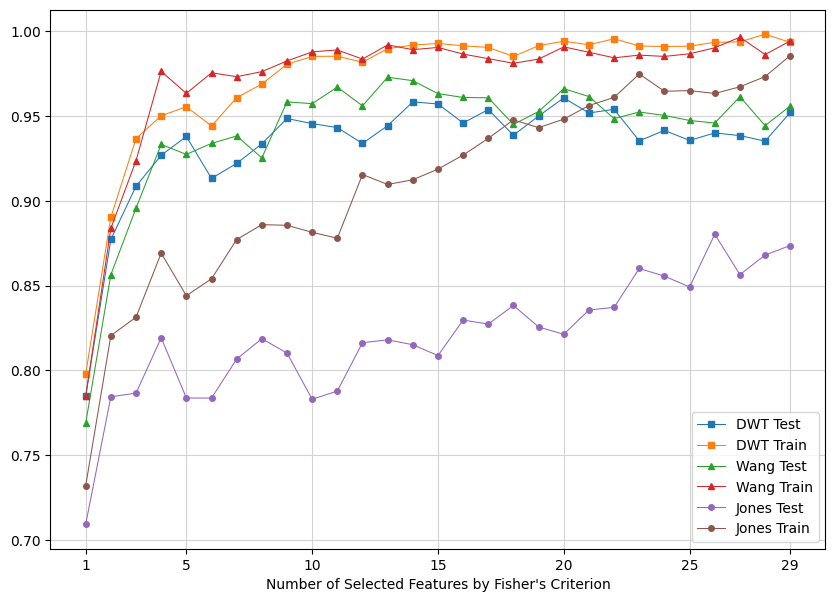

In [11]:
x = merged_feat_accuracy_svm['n_features']
y = merged_feat_accuracy_svm[['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones']]

plt.figure(figsize=(10, 7))

import itertools
marker = itertools.cycle(('s', 's', '^', '^', 'o', 'o')) 
for i in range(0,len(y.columns)):
    plt.plot(x, y.iloc[:, i], markersize= 4, marker = next(marker), linewidth=0.75)

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')
#plt.title('SVM with DWT, Wang, and Jones Methods for Ovarian 8-7-02')
plt.xlabel("Number of Selected Features by Fisher's Criterion")
#plt.ylabel('Accuracy')
plt.xticks([1, 5, 10, 15, 20, 25, 29])
plt.grid(color='lightgrey')

In [21]:
acc_dwt_topten_8 = svm(dwt_topten_8, n_iter=10000)
acc_wang_topten_8 = svm(wang_topten_8, n_iter=10000)
acc_jones_topten_8 = svm(jones_topten_8, n_iter=10000)

print('DWT Method Accuracy ', round(acc_dwt_topten_8['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_wang_topten_8['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_jones_topten_8['accuracy'].mean(), 4))

DWT Method Accuracy  0.9567
Wang Method Accuracy  0.9678
Jones Method Accuracy  0.7989


In [10]:
acc_dwt_topten_4 = svm(dwt_topten_4, n_iter=10000, balanced=True)
acc_wang_topten_4 = svm(wang_topten_4, n_iter=10000, balanced=True)
acc_jones_topten_4 = svm(jones_topten_4, n_iter=10000, balanced=True)

print('DWT Method Accuracy ', round(acc_dwt_topten_4['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_wang_topten_4['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_jones_topten_4['accuracy'].mean(), 4))

DWT Method Accuracy  0.8307
Wang Method Accuracy  0.8038
Jones Method Accuracy  0.8105
